In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
import os
import requests

pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print(f"[INFO] File doesn't exist, downloading...")
    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"
    response = requests.get(url)

    if response.status_code == 200:
        with open(pdf_path, "wb") as f:
            f.write(response.content)
        print(f"[INFO] The file has been download and saved as {pdf_path}")
    else:
        print(f"[INFO] Failed to download the file. Status code: {response.status_code}")

else:
    print(f"[INFO] File {pdf_path} exists.")

[INFO] File human-nutrition-text.pdf exists.


In [5]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text: str) -> str:
    """Performs minor formatting on text"""

    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def open_and_read_pdf(pdf_path: str) -> list[dict]:
    doc = fitz.open(pdf_path)
    pages_and_texts = []

    for page_number, page in tqdm(enumerate(doc)):
        text = page.get_text()
        text = text_formatter(text=text)

        pages_and_texts.append({
            "page_number": page_number - 41, # account for offset in the PDF
            "page_char_count": len(text),
            "page_word_count": len(text.split(" ")),
            "page_sentence_count_raw": len(text.split(". ")),
            "page_token_count": len(text) / 4,
            "text": text
        })

    return pages_and_texts
    
pages_and_texts = open_and_read_pdf(pdf_path=pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [6]:
import random

random.sample(pages_and_texts, k=3)

[{'page_number': 1041,
  'page_char_count': 84,
  'page_word_count': 17,
  'page_sentence_count_raw': 3,
  'page_token_count': 21.0,
  'text': 'PART XVIII  CHAPTER 18.  NUTRITIONAL ISSUES  Chapter 18. Nutritional Issues  |  1041'},
 {'page_number': 395,
  'page_char_count': 1781,
  'page_word_count': 304,
  'page_sentence_count_raw': 12,
  'page_token_count': 445.25,
  'text': 'Diseases Involving Proteins  UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN  NUTRITION PROGRAM AND HUMAN NUTRITION PROGRAM  As you may recall, moderation refers to having the proper amount  of a nutrient—having neither too little nor too much. A healthy diet  incorporates all nutrients in moderation. Low protein intake has  several health consequences, and a severe lack of protein in the  diet eventually causes death. Although severe protein deficiency is  a rare occurrence in children and adults in the United States, it  is estimated that more than half of the elderly in nursing homes  are protein-defici

In [7]:
# 1 token : 4 chars = x tokens : 100 chars
# x = chars / 4


In [8]:
import pandas as pd

df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,1,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,147,3,199.25,Contents Preface University of Hawai‘i at Mā...


In [9]:
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count
count,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00
std,348.86,560.38,95.83,6.55,140.10
min,-41.00,0.00,1.00,1.00,0.00
25%,260.75,762.00,134.00,5.00,190.50
50%,562.50,1231.50,216.00,10.00,307.88
75%,864.25,1603.50,272.00,15.00,400.88
max,1166.00,2308.00,430.00,39.00,577.00


In [10]:
from spacy.lang.en import English

nlp = English()

# add sentencizer pipeline
nlp.add_pipe("sentencizer")

# create document instance as an example
doc = nlp("This is a sentence. This another sentence. I like elephants.")
len(list(doc.sents))

3

In [11]:
list(nlp(pages_and_texts[600]["text"]).sents)

[Image by  Allison  Calabrese /  CC BY 4.0  Korsakoff syndrome can cause similar symptoms as beriberi such  as confusion, loss of coordination, vision changes, hallucinations,  and may progress to coma and death.,
 This condition is specific  to alcoholics as diets high in alcohol can cause thiamin deficiency.,
  Other individuals at risk include individuals who also consume diets  typically low in micronutrients such as those with eating disorders,  elderly, and individuals who have gone through gastric bypass  surgery.5  Figure 9.10 The Role of Thiamin  Figure 9.11 Beriberi, Thiamin Deficiency  5.,
 Fact Sheets for Health Professionals: Thiamin.,
 National  Institute of Health, Office of Dietary Supplements.,
   https://ods.od.nih.gov/factsheets/Thiamin- HealthProfessional/. Updated Feburary 11, 2016.,
  Accessed October 22, 2017.,
  Water-Soluble Vitamins  |  559]

In [12]:
# loop over each page
for item in tqdm(pages_and_texts):
    # get senteces
    item["sentences"] = list(nlp(item["text"]).sents)

    # convert sentences into string
    item["sentences"] = [str(sentence) for sentence in item["sentences"]]

    # count sentences
    item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [13]:
pages_and_texts[600]

{'page_number': 559,
 'page_char_count': 863,
 'page_word_count': 138,
 'page_sentence_count_raw': 9,
 'page_token_count': 215.75,
 'text': 'Image by  Allison  Calabrese /  CC BY 4.0  Korsakoff syndrome can cause similar symptoms as beriberi such  as confusion, loss of coordination, vision changes, hallucinations,  and may progress to coma and death. This condition is specific  to alcoholics as diets high in alcohol can cause thiamin deficiency.  Other individuals at risk include individuals who also consume diets  typically low in micronutrients such as those with eating disorders,  elderly, and individuals who have gone through gastric bypass  surgery.5  Figure 9.10 The Role of Thiamin  Figure 9.11 Beriberi, Thiamin Deficiency  5. Fact Sheets for Health Professionals: Thiamin. National  Institute of Health, Office of Dietary Supplements.   https://ods.od.nih.gov/factsheets/Thiamin- HealthProfessional/. Updated Feburary 11, 2016.  Accessed October 22, 2017.  Water-Soluble Vitamins  | 

In [14]:
df = pd.DataFrame(pages_and_texts)
df.describe().round(2)

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,page_sentence_count_spacy
count,1208.00,1208.00,1208.00,1208.00,1208.00,1208.00
mean,562.50,1148.00,199.50,10.52,287.00,10.32
std,348.86,560.38,95.83,6.55,140.10,6.30
min,-41.00,0.00,1.00,1.00,0.00,0.00
25%,260.75,762.00,134.00,5.00,190.50,5.00
50%,562.50,1231.50,216.00,10.00,307.88,10.00
75%,864.25,1603.50,272.00,15.00,400.88,15.00
max,1166.00,2308.00,430.00,39.00,577.00,28.00


### Chunking our sentences together

In [15]:
sentence_chunk_size = 10

def chunk_sentences(sentences: list[str], chunk_size: int) -> list[list[str]]:
    chunked_sentences = chunks_test = [sentences[i: i+chunk_size] for i in range(0, len(sentences), chunk_size)]

    return chunked_sentences


In [16]:
for item in tqdm(pages_and_texts):
    item["sentence_chunks"] = chunk_sentences(item["sentences"], chunk_size=sentence_chunk_size)
    item["chunk_count"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [17]:
pages_and_texts[600]

{'page_number': 559,
 'page_char_count': 863,
 'page_word_count': 138,
 'page_sentence_count_raw': 9,
 'page_token_count': 215.75,
 'text': 'Image by  Allison  Calabrese /  CC BY 4.0  Korsakoff syndrome can cause similar symptoms as beriberi such  as confusion, loss of coordination, vision changes, hallucinations,  and may progress to coma and death. This condition is specific  to alcoholics as diets high in alcohol can cause thiamin deficiency.  Other individuals at risk include individuals who also consume diets  typically low in micronutrients such as those with eating disorders,  elderly, and individuals who have gone through gastric bypass  surgery.5  Figure 9.10 The Role of Thiamin  Figure 9.11 Beriberi, Thiamin Deficiency  5. Fact Sheets for Health Professionals: Thiamin. National  Institute of Health, Office of Dietary Supplements.   https://ods.od.nih.gov/factsheets/Thiamin- HealthProfessional/. Updated Feburary 11, 2016.  Accessed October 22, 2017.  Water-Soluble Vitamins  | 

In [18]:
import re

pages_and_chunks = []

# loop over each page
for item in tqdm(pages_and_texts):

    # loop over each sentence chunk
    for sentence_chunk in item["sentence_chunks"]:
        chunk_dict = {}
        chunk_dict["page_number"] = item["page_number"]

        # joined sentences in chunk to form a paragraph
        joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()

        # clean up text
        joined_sentence_chunk = re.sub(r"/.([A-Z])", r". \1", joined_sentence_chunk)
        chunk_dict["sentence_chunk"] = joined_sentence_chunk

        # get some stats on our chunks
        chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
        chunk_dict["chunk_word_count"] = len(joined_sentence_chunk.split(" "))
        chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4

        pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [19]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 1111,
  'sentence_chunk': 'Image by Allison Calabrese . CC BY 4.0 Type 2 Diabetes The other 90 to 95 percent of diabetes cases are Type 2 diabetes. Type 2 diabetes is defined as a metabolic disease of insulin insufficiency, but it is also caused by muscle, liver, and fat cells no longer responding to the insulin in the body (Figure 18.4 “Healthy Individuals and Type 2 Diabetes” .In brief, cells in the body have become resistant to insulin and no longer receive the full physiological message of insulin to take up glucose from the blood. Thus, similar to patients with Type 1 diabetes, those with Type 2 diabetes also have high blood-glucose levels. Figure 18.4 Healthy Individuals and Type 2 Diabetes Threats to Health | 1111',
  'chunk_char_count': 703,
  'chunk_word_count': 123,
  'chunk_token_count': 175.75}]

In [20]:
df = pd.DataFrame(pages_and_chunks)
df.describe().round(2)

,page_number,chunk_char_count,chunk_word_count,chunk_token_count
count,1843.00,1843.00,1843.00,1843.00
mean,583.38,730.55,109.22,182.64
std,347.79,445.59,69.33,111.40
min,-41.00,12.00,3.00,3.00
25%,280.50,313.00,43.00,78.25
50%,586.00,743.00,111.00,185.75
75%,890.00,1112.00,168.00,278.00
max,1166.00,1823.00,290.00,455.75


In [21]:
df.head()

,page_number,sentence_chunk,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-37,Contents Preface University of Hawai‘i at Māno...,765,115,191.25
4,-36,Lifestyles and Nutrition University of Hawai‘i...,939,142,234.75


### Filter chunks of text for short chunks

In [22]:
min_token_length = 30

for _, row in df[df["chunk_token_count"] <= min_token_length].sample(5).iterrows():
    print(f'chunk token count: {row["chunk_token_count"]} | text: {row["sentence_chunk"]}')

chunk token count: 9.25 | text: Protein’s Functions in the Body | 387
chunk token count: 20.25 | text: http://pressbooks.oer.hawaii.edu/ humannutrition2/?p=118  132 | The Immune System
chunk token count: 4.5 | text: 708 | Introduction
chunk token count: 26.25 | text: Updated November 6, 2015. Accessed April 15, 2018. 1122 | Undernutrition, Overnutrition, and Malnutrition
chunk token count: 12.25 | text: PART VI CHAPTER 6.PROTEIN Chapter 6.Protein | 357


In [23]:
pages_and_chunks_over_min_token_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_token_len[:2]

[{'page_number': -39,
  'sentence_chunk': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'sentence_chunk': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

### Embedding our text chunks

In [26]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

In [27]:
%%time

# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 14.5 µs


In [28]:
# embedding_model = embedding_model.to("mps")

# for item in tqdm(pages_and_chunks_over_min_token_len):
#     item["embedding"] = embedding_model.encode(item["sentence_chunk"])

In [29]:
text_chunks = [item["sentence_chunk"] for item in pages_and_chunks_over_min_token_len]

In [30]:
%%time

text_chunk_embeddings = embedding_model.encode(text_chunks, batch_size=32, convert_to_tensor=True)

CPU times: user 29.3 s, sys: 517 ms, total: 29.8 s
Wall time: 11.7 s


In [54]:
text_chunk_embeddings.shape

(1680, 768)

In [31]:
text_chunk_embeddings = text_chunk_embeddings.cpu().numpy()

In [32]:
for i, item in enumerate(pages_and_chunks_over_min_token_len):
    item["embedding"] = text_chunk_embeddings[i]

In [34]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_token_len)
embeddings_df_save_path = "text_chunks_and_embeddings_df.csv"
text_chunks_and_embeddings_df.to_csv(embeddings_df_save_path, index=False)

(1680,)

In [100]:
import torch
import pandas as pd
import numpy as np
import random

text_chunks_and_embedding_df = pd.read_csv("text_chunks_and_embeddings_df.csv")
text_chunks_and_embedding_df["embedding"] = text_chunks_and_embedding_df["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

pages_and_chunks = text_chunks_and_embedding_df.to_dict(orient="records")

embeddings = torch.tensor(np.array(text_chunks_and_embedding_df["embedding"].tolist()), dtype=torch.float32).to(device)

In [101]:
embeddings.shape

torch.Size([1680, 768])

In [102]:
from sentence_transformers import util, SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

In [111]:
from time import perf_counter as timer

query = "macronutrients functions"
print(f"Query: {query}")

query_embedding = embedding_model.encode(query, convert_to_tensor=True)

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)
end_time = timer()

print(f"Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds")

top_results_dot_product = torch.topk(dot_scores, k=5)
top_results_dot_product

Query: macronutrients functions
Time taken to get scores on 1680 embeddings: 0.00011 seconds


torch.return_types.topk(
values=tensor([[0.6926, 0.6738, 0.6646, 0.6536, 0.6473]], device='cuda:0'),
indices=tensor([[42, 47, 41, 51, 46]], device='cuda:0'))

In [113]:
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [121]:
print_wrapped(pages_and_chunks[100]["sentence_chunk"])

Nutrition Assessment Nutritional assessment is the interpretation of
anthropometric, biochemical (laboratory), clinical and dietary data to determine
whether a person or groups of people are well nourished or malnourished
(overnourished or undernourished). Nutritional assessment can be done using the
ABCD methods. These refer to the following: • A. Anthropometry • B. Biochemical
methods • C. Clinical methods • D. Dietary methods Anthropometry methods of
assessing nutritional status The word anthropometry comes from two words:
Anthropo means ‘human’ and metry means ‘measurement’. The different measurements
taken to assess growth and body composition are presented below. To assess
growth, several different measurements including length, height, weight, head
circumference, mid-arm circumference, skin-fold thickness, head/chest ratio, and
hip/waist ratio can be used.Height and weight measurements are essential in
children to evaluate physical growth.As an additional resource, the NHANES
An

In [136]:
top_results_dot_product.indices[0][0]

tensor(42, device='cuda:0')

In [138]:
print(f"Query: '{query}'\n")
print("Results:")

for score, idx in zip(top_results_dot_product.values[0], top_results_dot_product.indices[0]):
    print(f"Score: {score:.4f}")

    print("Text:")
    print_wrapped(pages_and_chunks[idx]["sentence_chunk"])

    print(f"Page number: {pages_and_chunks[idx]['page_number']}")
    print("\n")

Query: 'macronutrients functions'

Results:
Score: 0.6926
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients.There are three classes of macronutrients: carbohydrates, lipids,
and proteins.These can be metabolically processed into cellular energy.The
energy from macronutrients comes from their chemical bonds.This chemical energy
is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions.A unit of measurement of
food energy is the calorie.On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand.A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels.Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohydrates
are molecule

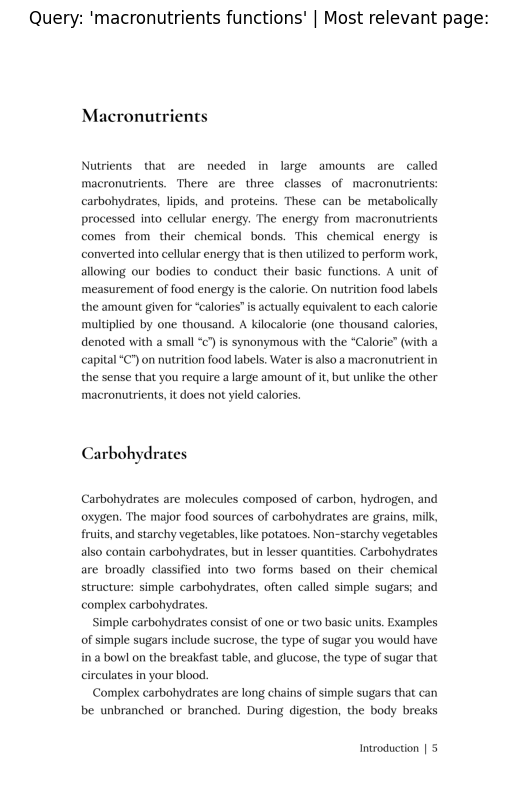

In [145]:
import fitz
import matplotlib.pyplot as plt

pdf_path = "human-nutrition-text.pdf"
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41)

# get the image of the page
img = page.get_pixmap(dpi=600)

doc.close()

# convert the pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv, dtype=np.uint8).reshape((img.h, img.w, img.n))

plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis("off")
plt.show()

In [148]:
import torch

def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    # compute dot product
    dot_product = torch.dot(vector1, vector2)

    # compute euclidean/l2 norm of each vector
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

# example tensors
vector1 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector2 = torch.tensor([1, 2, 3], dtype=torch.float32)
vector3 = torch.tensor([4, 5, 6], dtype=torch.float32)
vector4 = torch.tensor([-1, -2, -3], dtype=torch.float32)

# calculate dot product
print("dot product between vector1 and vector2: ", dot_product(vector1, vector2))
print("dot product between vector1 and vector3: ", dot_product(vector1, vector3))
print("dot product between vector1 and vector4: ", dot_product(vector1, vector4))

# calculate cosine similarity
print("cosine similarity between vector1 and vector2: ", cosine_similarity(vector1, vector2))
print("cosine similarity between vector1 and vector3: ", cosine_similarity(vector1, vector3))
print("cosine similarity between vector1 and vector4: ", cosine_similarity(vector1, vector4))

dot product between vector1 and vector2:  tensor(14.)
dot product between vector1 and vector3:  tensor(32.)
dot product between vector1 and vector4:  tensor(-14.)
cosine similarity between vector1 and vector2:  tensor(1.0000)
cosine similarity between vector1 and vector3:  tensor(0.9746)
cosine similarity between vector1 and vector4:  tensor(-1.0000)


### Functionizing our semantic search pipeline

In [153]:
def retrieve_relevant_resources(
    query: str,
    embeddings: torch.tensor,
    model: SentenceTransformer=embedding_model,
    n_resources_to_return: int=5,
    print_time: bool=True
):
    """
    Embeds a query with model and returns top k scores and indices from embeddings.
    """

    # embed query
    query_embedding = model.encode(query, convert_to_tensor=True)

    # get dot product scores on embeddings
    start_time = timer()
    dot_scores = util.dot_score(query_embedding, embeddings)[0]
    end_timer = timer()

    if print_time:
        print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time:.5f} seconds.")

    scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)

    return scores, indices

def print_top_results_and_scores(
    query: str,
    embeddings: torch.tensor,
    pages_and_chunks: list[dict]=pages_and_chunks,
    n_resources_to_return: int=5
):
    """
    Takes a query, retrieves most relevant resources and print tehm out in descending order.
    """

    scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings, n_resources_to_return=n_resources_to_return)

    print(f"Query: {query}\n")
    print("Results:")
    for score, index in zip(scores, indices):
        print(f"Score: {score:.4f}")
        print_wrapped(pages_and_chunks[index]["sentence_chunk"])
        print(f"Page number: {pages_and_chunks[index]['page_number']}")
        print("\n")

In [152]:
query = "symptoms of pellagra"

retrieve_relevant_resources(query=query, embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: -5172.84326 seconds.


(tensor([0.5000, 0.3741, 0.2959, 0.2783, 0.2721], device='cuda:0'),
 tensor([ 822,  853, 1536, 1555, 1531], device='cuda:0'))